# Oracles
### Introduction
Oracles can be thought of like blackboxes. You can't know what's inside. You don't need to know what's inside. You just need to understand that it takes some input and maps them to some output.

This notebook will guide you through the ideas to implement some basic oracles, using Qiskit. These oracles could be used in many quantum algorithms, because we are more concerned about how to obtain information out of the oracles, rather than what is actually going on in them. 

1. *OrOracle()*
2. *AndOracle()*
3. *ControlledOnInt()*
4. *ControlledOnBit()*

Lastly, one of the oracles, *ControlledOnInt()* would be demonstrated and used in Grover's algorithm. 

### Importing Libraries
1. *n* : the number of qubits

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from qiskit import IBMQ, Aer, BasicAer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import state_fidelity
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library.generalized_gates.mcmt import MCMT
from qiskit.circuit.library.standard_gates.x import XGate, HGate
from qiskit.circuit.library import ZGate
from qiskit.visualization import plot_histogram

In [2]:
n = 5

## OrOracle

The purpose of the *OrOracle()* is to tell whether at least one qubit in the quantum register is a '1'. Algorithmically, it is sufficient to check if all the qubits are '0'. If so, the ancilla qubit will remain '0'. 

#### Main Idea
To implement the oracle, all qubits in the qubit register, as well as the ancilla qubit, are flipped. If the resultant register is all in the '1' state, it means none of them are '1' in the first place, hence ancilla qubit will be flipped back to '0' (by using a *XGate* controlled on all qubits in the register, targetted on the ancilla qubit). Otherwise, the ancilla qubit remains in '1', indicating that initially, at least one qubit is in the '1' state.

At the end of the Oracle, all qubits in the register are flipped back to their original states. (Oracles should not change the state of the qubits.)

#### Pseudo-Code
1. *X* on all qubits in the quantum register.
2. *X* on the ancilla qubit.
3. *ControlledX* targetted on ancilla qubit, controlled on all qubits in the quantum register.
4. (Reset) Flip all qubits in the quantum register.

In [3]:
or_q = QuantumRegister(n)
or_c = ClassicalRegister(1)
or_circuit = QuantumCircuit(or_q, or_c)

In [4]:
# INPUT THE QUBITS TO TOGGLE
or_circuit.x(1)

In [5]:
# nn = size of given_circuit
def OrOracle(given_circuit, nn, target_qubit):
    given_circuit.barrier()
    given_circuit.x(target_qubit)
    controlled_xgate = XGate().control(nn)
    for i in range(nn):
        given_circuit.x(i)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_xgate, curlist)
    for i in range(nn):
        given_circuit.x(i)
    given_circuit.barrier()


def OrOracleGate(given_circuit, nn, target_qubit, gate):
    given_circuit.barrier()
    given_circuit.append(gate, [target_qubit])
    controlled_gate = (gate.inverse()).control(nn)
    for i in range(nn):
        given_circuit.x(i)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_gate, curlist)
    for i in range(nn):
        given_circuit.x(i)
    given_circuit.barrier()

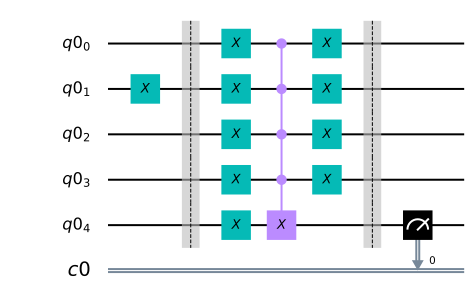

In [6]:
OrOracle(or_circuit, n - 1, n - 1)
or_circuit.measure(n - 1, 0)
or_circuit.draw('mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(or_circuit, simulator, shots=1000).result().get_counts(or_circuit)
print("The results for OrOracle are:",counts)

The results for OrOracle are: {'1': 1000}


#### OrOracle with User-Specified Gate
Sometimes, it is useful to have an Oracle that does a user-specified function on the ancilla qubit, rather than just a *XGate*. The function *OrOracleGate()* is implemented to do that. The key difference is that the specified gate is first applied to the ancilla qubit. If all qubits are '0' initially, the inverse gate (since all operators are unitary) is applied to the ancilla qubit (controlled on all qubits in the quantum register).

Now we try experimenting with *OrOracleGate()*, using *HGate* as an example.

In [8]:
orf_q = QuantumRegister(n)
orf_c = ClassicalRegister(1)
orf_circuit = QuantumCircuit(orf_q, orf_c)

for i in range(4):
    orf_circuit.x(i)

OrOracleGate(orf_circuit, n - 1, n - 1, HGate())

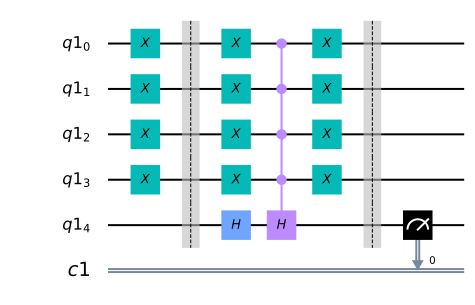

In [9]:
orf_circuit.measure(n - 1, 0)
orf_circuit.draw('mpl')

In [10]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(orf_circuit, simulator, shots=1000).result().get_counts(orf_circuit)
print("The results for OrOracleGate are:",counts)

The results for OrOracleGate are: {'0': 507, '1': 493}


## AndOracle

The purpose of the *AndOracle()* is to tell whether all the qubits in the quantum register are '1'. If so, the ancilla qubit is flipped to '1'. Otherwise, it remains at '0'. 

#### Main Idea
AndOracle is simpler than OrOracle, in the sense that the controlled Gate could be directly applied. Since all qubits in the register must be '1' to perform an operator on the ancilla qubit, a *XGate*, targetted on the ancilla qubit and controlled on all qubits in the quantum register, will do the job. 

Since the qubits in the quantum register did not change, no further operation is necessary.

#### Pseudo-Code
1. *ControlledX* targetted on ancilla qubit, controlled on all qubits in the quantum register.

In [11]:
and_q = QuantumRegister(n)
and_c = ClassicalRegister(1)
and_circuit = QuantumCircuit(and_q, and_c)

In [12]:
# INPUT THE QUBITS TO TOGGLE
for i in range(n - 1):
    and_circuit.x(i)

In [13]:
#nn = size of given_circuit
def AndOracle(given_circuit, nn, target_qubit):
    given_circuit.barrier()
    controlled_xgate = XGate().control(nn)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_xgate, curlist)
    given_circuit.barrier()
    
def AndOracleGate(given_circuit, nn, target_qubit, gate):
    given_circuit.barrier()
    controlled_gate = gate.control(nn)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_gate, curlist)
    given_circuit.barrier()

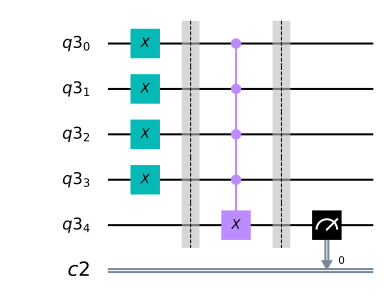

In [14]:
AndOracle(and_circuit, n - 1, n - 1)
and_circuit.measure(n - 1, 0)
and_circuit.draw('mpl')

In [15]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(and_circuit, simulator, shots=1000).result().get_counts(and_circuit)
print("The results for AndOracle are:",counts)

The results for AndOracle are: {'1': 1000}


#### AndOracle with User-Specified Gate
Similarly, *AndOracleGate()* is implemented to allow more variations of the *AndOracle()*.

Here, we experiment with a *HGate*. 

In [16]:
andf_q = QuantumRegister(n)
andf_c = ClassicalRegister(1)
andf_circuit = QuantumCircuit(andf_q, andf_c)

#andf_circuit.x(0)
andf_circuit.x(1)
andf_circuit.x(2)
andf_circuit.x(3)

AndOracleGate(andf_circuit, n - 1, n - 1, HGate())

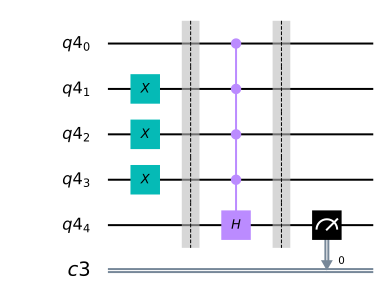

In [17]:
andf_circuit.measure(n - 1, 0)
andf_circuit.draw('mpl')

In [18]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(andf_circuit, simulator, shots=1000).result().get_counts(andf_circuit)
print("The results for AndOracleGate are:",counts)

The results for AndOracleGate are: {'0': 1000}


## ControlledOnIntOracle

The purpose of the *ControlledOnIntOracle(x)* is to tell whether the qubits in the quantum register are in the state of *x* when *x* is expressed in binary. If so, the ancilla qubit is flipped to '1'. Otherwise, it remains at '0'.

*ControlledOnIntOracle()* can often prove to be very useful, because it can be used in all sorts of oracles. Particularly, it can be used to brute force some specific values for wavefunctions, or to create some edge cases. Its power could be seen in Grover's Algorithm later on.

#### Main Idea
The idea of *ControlledOnInt(x)* is similar to the implementation of *OrOracle()*. Take an integer *x* and express it in binary. Starting from the least significant bit of *x*, if the bit is '0', flip the respective qubit in the quantum register. In *OrOracle()*, all the qubits in the quantum register are flipped, whereas here, only the qubits in the same position as the bits which are '1' in the binary representation of *x* are flipped. A *XGate*, targetted on the ancilla qubit and controlled on all qubits in the quantum register, will be applied. Finally, all the qubits are reverted back to the original states, by repeating the flipping described earlier.

#### Pseudo-Code
1. Express *x* in binary. 
2. Starting from the least significant bit, X the qubits in the same position as '1's in the binary of *x*.
3. *ControlledX* targetted on ancilla qubit, controlled on all qubits in the quantum register.
4. X on all the previously flipped qubits to revert the quantum register to its original state.

In [19]:
coi_q = QuantumRegister(n + 1)
coi_c = ClassicalRegister(1)
coi_circuit = QuantumCircuit(coi_q, coi_c)

In [20]:
# nn = number of qubits in the quantum register, excluding the target_qubit
def ControlledOnIntOracle(given_circuit, nn, target_qubit, x, reverse=False):
    
    if (x != 0 and nn < int(math.floor(math.log2(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    
    given_circuit.barrier()
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    AndOracle(given_circuit, nn, target_qubit)
    
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    given_circuit.barrier()
    
def ControlledOnIntOracleGate(given_circuit, nn, target_qubit, x, gate, reverse=False):
    
    if (x != 0 and nn < int(math.floor(math.log2(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    
    given_circuit.barrier()
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    AndOracleGate(given_circuit, nn, target_qubit, gate)
    
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    given_circuit.barrier()

In [21]:
coi_circuit.x(0)
coi_circuit.x(1)
coi_circuit.x(3)
coi_circuit.x(4)
coi_circuit.barrier()

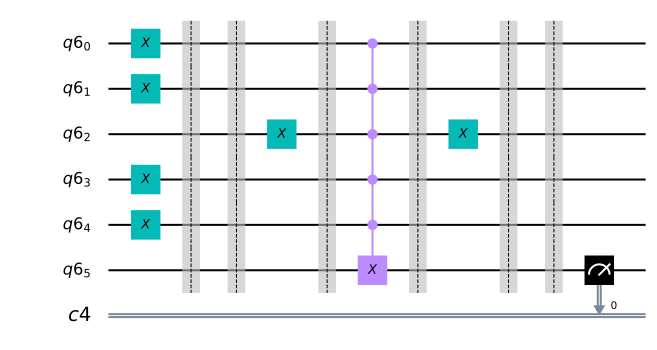

In [22]:
ControlledOnIntOracle(coi_circuit, 5, 5, 27)
coi_circuit.barrier()
coi_circuit.measure(5, 0)
coi_circuit.draw('mpl')

In [23]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(coi_circuit, simulator, shots=1000).result().get_counts(coi_circuit)
print("The results for ControlledOnIntOracle are:",counts)

The results for ControlledOnIntOracle are: {'1': 1000}


#### ControlledOnIntOracle with User-Specified Gate
Similarly, *ControlledOnIntOracleGate()* is implemented to allow more variations of the *ControlledOnIntOracle()*.

Here, we experiment with a *HGate*. 

In [24]:
coif_q = QuantumRegister(n + 1)
coif_c = ClassicalRegister(1)
coif_circuit = QuantumCircuit(coif_q, coif_c)

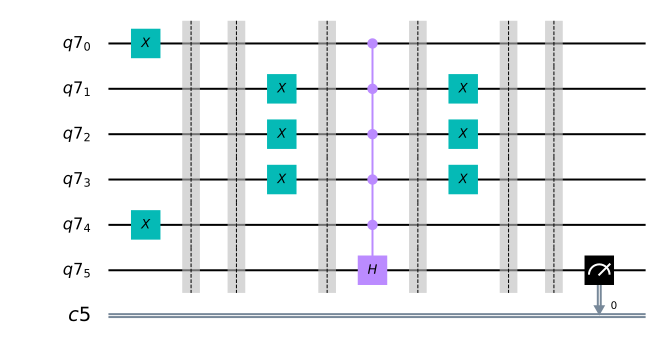

In [25]:
coif_circuit.x(0)
coif_circuit.x(4)
coif_circuit.barrier()

ControlledOnIntOracleGate(coif_circuit, n, n, 17, HGate())
coif_circuit.barrier()
coif_circuit.measure(n, 0)
coif_circuit.draw('mpl')

In [27]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(coif_circuit, simulator, shots=1000).result().get_counts(coif_circuit)
print("The results for ControlledOnIntOracleGate are:",counts)

The results for ControlledOnIntOracleGate are: {'0': 498, '1': 502}


### ControlledOnIntOracle used in Grover's Algorithm

#### Introduction
Grover's Algorithm relies on an oracle that, given *x*, can tell you if *x* is desired or not. It is good to think of it as a function *f*, such that *f(x) = 1* only for marked inputs, and *f(x) = 0* otherwise.
#### My Own Interpretation of Grover's Algorithm
I personally had many misconceptions when I first learned Grover's Algorithm. It's very difficult to clear these misconceptions or search them online due to me not knowing how to phrase my questions. But through reading several books and papers, this is my current interpretation of the algorithm.

Grover's Algorithm cannot be used to search for real databases, at least not without encoding the database in the quantum state to be amplitude amplified. If the quantum encoding is done naively, the cost of creating this database (and also the oracle) is $O(N)$. The $O(\sqrt{N})$ complexity comes from the number of calls made to the quantum oracle. In a classical oracle or classical database, this is impossible, meaning $O(N)$ is still the best time complexity classically.

What I am demonstrating now is a method to code out such an oracle using *ControlledOnIntOracle()*. I am not saying this is the most efficient way or the way with least time complexity; I'm just saying it offers an easy way for us to experiment on our algorithm, without focusing too much on the implementation of the oracle.

In Grover's Search Algorithm, *ControlledOnIntOracle()* could be used as the oracle to highlight marked element(s).

In [28]:
newn = 6
grover_qc = QuantumCircuit(newn + 1, newn, name = "Grover Circuit")

In [29]:
def GroverOracle(given_circuit, nn, indices_to_mark, name = 'Oracle'):
    for i in indices_to_mark:
        ControlledOnIntOracle(given_circuit, nn, nn, i)

def DiffusionOperator(given_circuit, nn, name = "Diffusion Operator"):
    given_circuit.h(range(nn))
    given_circuit.x(range(nn))
    controlled_gate = ZGate().control(nn - 1)
    given_circuit.append(controlled_gate, list(range(0, nn)))
    given_circuit.x(range(nn))
    given_circuit.h(range(nn))

def GroverAlgorithm(given_circuit, nn, indices_of_marked_elements):
    
    r = int(np.floor(np.pi/4*np.sqrt(2**nn/len(indices_of_marked_elements))))
    print(f'{nn} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    given_circuit.h(range(nn))
    
    for _ in range(r):
        GroverOracle(given_circuit, nn, indices_of_marked_elements)
        DiffusionOperator(given_circuit, nn)

    given_circuit.measure(range(nn), range(nn))

In [30]:
GroverAlgorithm(grover_qc, newn, [22, 42])

6 qubits, basis states [22, 42] marked, 4 rounds


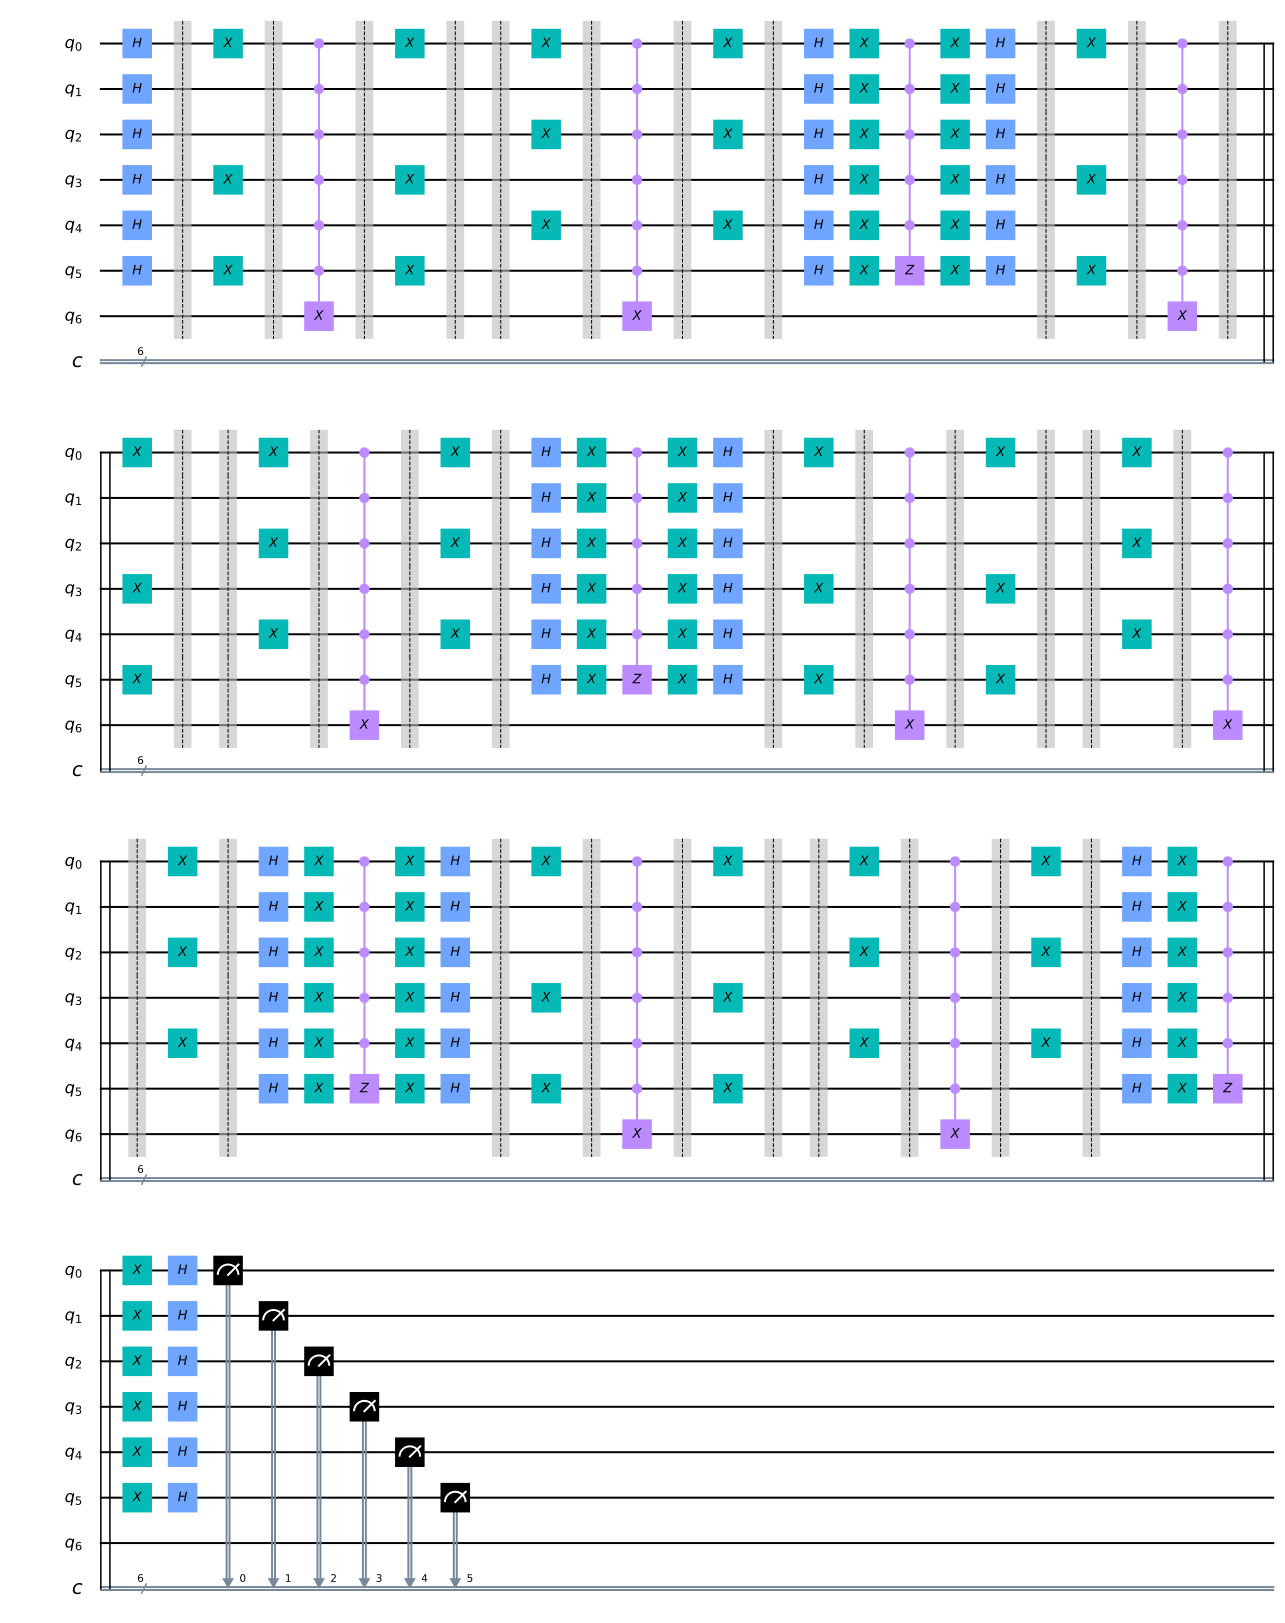

In [31]:
grover_qc.draw('mpl')

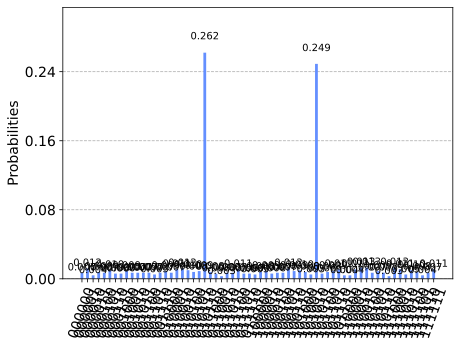

In [32]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=1000).result().get_counts(grover_qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

### Final Note
As can be seen above, the states *|22>* and *|42>* have the highest probabilities. 

### Reference
1. Qiskit Global Summer School Lab 2